In [1]:
import torch
import pandas as pd
from transformers import AutoImageProcessor, TimesformerForVideoClassification
from transformers import TimesformerModel, logging
from src.models.video.models.timesformer import TimeSformer
from src.preprocessing.video.utils import normalize_path

data = pd.read_csv("D:\\projects\\v2v\\v5\\data\\timesformer_dataset.csv", sep = ";")

In [ ]:
import os
import time
from tqdm import tqdm
import torch
from torch import nn
from torch.optim import Adam, AdamW
from transformers import VideoMAEForVideoClassification, logging
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

from src.models.video.utils import AverageMeter
from src.models.video.labels import EVENT_DICTIONARY_V2, INVERSE_EVENT_DICTIONARY_V2

label2id = EVENT_DICTIONARY_V2
id2label = INVERSE_EVENT_DICTIONARY_V2
backbone = VideoMAEForVideoClassification.from_pretrained("anirudhmu/videomae-base-finetuned-soccer-action-recognitionx4", 
                                                num_frames= 18,
                                                label2id = label2id,
                                                id2label = id2label, 
                                                ignore_mismatched_sizes=True)

In [2]:
import av
import numpy as np

from transformers import AutoImageProcessor, TimesformerModel

np.random.seed(0)


def read_video_pyav(container, indices):
    '''
    Decode the video with PyAV decoder.
    Args:
        container (`av.container.input.InputContainer`): PyAV container.
        indices (`List[int]`): List of frame indices to decode.
    Returns:
        result (np.ndarray): np array of decoded frames of shape (num_frames, height, width, 3).
    '''
    frames = []
    container.seek(0)
    start_index = indices[0]
    end_index = indices[-1]
    for i, frame in enumerate(container.decode(video=0)):
        if i > end_index:
            break
        if i >= start_index and i in indices:
            frames.append(frame)
    return np.stack([x.to_ndarray(format="rgb24") for x in frames])


def sample_frame_indices(clip_len, frame_sample_rate, seg_len):
    '''
    Sample a given number of frame indices from the video.
    Args:
        clip_len (`int`): Total number of frames to sample.
        frame_sample_rate (`int`): Sample every n-th frame.
        seg_len (`int`): Maximum allowed index of sample's last frame.
    Returns:
        indices (`List[int]`): List of sampled frame indices
    '''
    converted_len = int(clip_len * frame_sample_rate)
    end_idx = np.random.randint(converted_len, seg_len)
    start_idx = end_idx - converted_len
    indices = np.linspace(start_idx, end_idx, num=clip_len)
    indices = np.clip(indices, start_idx, end_idx - 1).astype(np.int64)
    return indices

In [3]:
container = av.open("F:\\video_classification\\2014-11-04 - 22-45 Arsenal 3 - 3 Anderlecht\\chunk_8\\visual\\video_8_start_480_end_540.mp4")
indices = sample_frame_indices(clip_len=60, frame_sample_rate= 15, seg_len=container.streams.video[0].frames)
video = read_video_pyav(container, indices)

In [23]:
import os
import torch
from PIL import Image

video_path = "F:\\video_classification\\2014-11-04 - 22-45 Arsenal 3 - 3 Anderlecht\\chunk_91\\visual\\video_91_start_2805_end_2865.mp4"
image_extractor_path = "facebook/timesformer-base-finetuned-k400"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
image_processor = AutoImageProcessor.from_pretrained("facebook/timesformer-base-finetuned-k400", use_fast = True)


container = av.open(video_path)
indices = sample_frame_indices(clip_len=60, frame_sample_rate= 15, seg_len=container.streams.video[0].frames)
video = read_video_pyav(container, indices)

inputs = image_processor(list(video), return_tensors="pt").to(device)
# inputs


In [21]:
from torch.optim import Adam

model = TimeSformer(30, 17).to(device)
ckpt = torch.load("./ds_tv360_model_timesformer_nepochs_2_nframes_30.pth")

optimizer = Adam([{"params": model.parameters(), "lr": 0.00001}])
model.backbone.load_state_dict(ckpt["backbone"])
model.classifier.load_state_dict(ckpt["classifier"])
optimizer.load_state_dict(ckpt["optimizer"])

Some weights of TimesformerModel were not initialized from the model checkpoint at fcakyon/timesformer-large-finetuned-k400 and are newly initialized because the shapes did not match:
- timesformer.embeddings.time_embeddings: found shape torch.Size([1, 96, 768]) in the checkpoint and torch.Size([1, 30, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [45]:
threshold = 0.6
with torch.no_grad():
    outputs = model.backbone(**inputs)
    logits = model.classifier(outputs[0][:, 0])
    probabilities = torch.sigmoid(logits)
    predictions = (probabilities >= threshold).int() 
    print(probabilities)
    print(predictions)
    

RuntimeError: shape '[1, 24, 14, 30, 768]' is invalid for input of size 7977984

In [27]:
torch.full((17,), 0.55, device="cuda")

tensor([0.5500, 0.5500, 0.5500, 0.5500, 0.5500, 0.5500, 0.5500, 0.5500, 0.5500,
        0.5500, 0.5500, 0.5500, 0.5500, 0.5500, 0.5500, 0.5500, 0.5500],
       device='cuda:0')

In [6]:
def binary2label(values: torch.Tensor):
    return torch.nonzero(values[0], as_tuple=True)[0].tolist()

In [26]:
import torch

# Giả sử threshold khác nhau cho từng class (có thể thay đổi giá trị theo yêu cầu)
thresholds = torch.tensor([0.400, 0.500, 0.500, 0.5500, 0.5500, 0.700, 0.700, 0.700, 0.700,
        0.6500, 0.52, 0.52, 0.65, 0.55, 0.65, 0.65, 0.65],
       device='cuda:0')

with torch.no_grad():
    outputs = model.backbone(**inputs)
    logits = model.classifier(outputs[0][:, 0])  # (batch_size, 17)
    probabilities = torch.sigmoid(logits)  # (batch_size, 17)

    # So sánh từng giá trị với threshold tương ứng
    predictions = (probabilities >= thresholds).int()

    print(probabilities)
    print(predictions)
    print(binary2label(predictions))

# tensor([[0.0658, 0.2289, 0.2500, 0.4105, 0.3129, 0.5913, 0.5936, 0.5728, 0.9524,
#          0.8809, 0.8384, 0.6186, 0.3348, 0.5612, 0.3578, 0.0251, 0.0442]],


tensor([[0.2978, 0.3940, 0.3271, 0.3950, 0.3441, 0.4660, 0.4212, 0.5003, 0.7187,
         0.6485, 0.5439, 0.5422, 0.3975, 0.4595, 0.3942, 0.2028, 0.2117]],
       device='cuda:0')
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0]], device='cuda:0',
       dtype=torch.int32)
[8, 10, 11]


In [12]:
import os
import math
import numpy
import torch
import json
from tqdm import tqdm
from typing import Optional, Dict
from PIL import Image
from typing import List

from torch.optim import Adam  # noqa
from transformers import TimesformerModel
from transformers import AutoImageProcessor

from src.logger import Logging
from src.models.video.models.timesformer import TimeSformer
from src.models.video.labels import INVERSE_EVENT_DICTIONARY_V2, EVENT_DICTIONARY_V2

logger = Logging()

class TimeSformerInferencing:
    def __init__(self,
                num_frames: int = 4,
                num_classes: int = 18,
                model: str = 'timesformer',
                image_extractor: str = "facebook/timesformer-base-finetuned-k600",
                device: str = 'cuda:0',
                label2id: Optional[Dict] = EVENT_DICTIONARY_V2,
                id2label: Optional[Dict] = INVERSE_EVENT_DICTIONARY_V2,
                game_name: str = None,
                checkpoint: str = None):
        self.image_extractor = image_extractor
        self.num_frames = num_frames
        self.num_classes = num_classes
        self.device = device if torch.cuda.is_available() else 'cpu'
        if self.device == 'cpu': 
            logger.warning("Inferencing with CPU, the process might be 4 times slowwer than user")
        self.model = model
        if self.model == 'timesformer':
            self.initial_model = TimeSformer(self.num_frames, self.num_classes).to(self.device)
        self.game_name = game_name
        # label dictdict
        self.label2id = label2id if label2id is not None else EVENT_DICTIONARY_V2
        self.id2label = id2label if id2label is not None else INVERSE_EVENT_DICTIONARY_V2
        
        # Initialize model checkpoint
        if checkpoint is not None:
            try:
                ckpt = torch.load(checkpoint)
                optimizer = Adam([{"params": self.initial_model.parameters(), "lr": 0.00001}])
                self.initial_model.backbone.load_state_dict(ckpt["backbone"])
                self.initial_model.classifier.load_state_dict(ckpt["classifier"])
                optimizer.load_state_dict(ckpt["optimizer"])
            except Exception as e:
                logger.error(f"Failed to load checkpoint: {e}")
                raise ValueError("Checkpoint loading failed. Recheck filepath")
    
    @staticmethod
    def binary_to_id(values: torch.Tensor):
        return torch.nonzero(values[0], as_tuple=True)[0].tolist()
    
    @staticmethod
    def id_to_label(values):
        return [INVERSE_EVENT_DICTIONARY_V2.get(id, "Event not recognized") for id in values]
    
    def listgame(self):
        frames_per_game = sorted([f"{self.game_name}/{i}/frames" for i in os.listdir(self.game_name) \
            if not (i.endswith(".json") or i.endswith('.csv'))], \
                key = lambda x: int(x.split("/")[-2].split("_")[-1])
                )
        return frames_per_game
    
    def sample_frames_indices(self, video: str, method: str, spacing: int):
        list_frames = [f"{video}/{i}" for i in os.listdir(video) if not i.endswith(".json")]
        if method == 'from_top':
            start_idx = 0
            end_idx = len(list_frames) - 1
            # Giới hạn số lượng indices tối đa theo x
            actual_spacing = min(spacing, self.num_frames, len(list_frames))
            
            indices = numpy.linspace(start_idx, end_idx, actual_spacing)
            indices = numpy.clip(indices, start_idx, end_idx - 1).astype(numpy.int64)
        elif method == 'from_middle':
            center_idx = math.ceil(len(list_frames) / 2) - 1
            half_spacing = spacing // 2
            
            # Xác định khoảng lấy mẫu
            start_idx = max(0, center_idx - half_spacing)
            end_idx = min(len(list_frames) - 1, center_idx + half_spacing)
            
            # Giới hạn số lượng indices tối đa theo x
            actual_spacing = min(spacing, self.num_frames, len(list_frames))
            
            indices = numpy.linspace(start_idx, end_idx, actual_spacing)
            indices = numpy.clip(indices, 0, len(list_frames) - 1).astype(numpy.int64)
        elif method == "from_bottom":
            print('''
                This method has not been supported in this version.
                Please use from_middle/from_top instead  
                ''')
            pass
        frames_list = []  
        for i, j in enumerate(list_frames):
            if i in indices:
                frames_list.append(j)
        
        frames_list = [Image.open(img).convert('RGB') for img in frames_list]
        
        return frames_list
     
    def prepare_inputs(self, video: str, method: str, spacing: int):
        game = self.sample_frames_indices(video, method, spacing)
        image_processor = AutoImageProcessor.from_pretrained(
            self.image_extractor,
            use_fast = True
        )
        inputs = image_processor(list(game), return_tensors="pt").to(self.device)
        return inputs
    
    def run(self,
            method: str,
            spacing: int,
            threshold = None):
        if threshold is None:
            threshold = torch.tensor([0.3312, 0.500, 0.3839, 0.4127, 0.5500, 0.700, 0.700, 0.90, 0.90,
                                    0.5680, 0.75, 0.5678, 0.41, 0.4128, 0.65, 0.4128, 0.2411]).to(self.device)
        
        video_list = self.listgame()
        self.initial_model.eval()
        prediction_games = []
        for video in tqdm(video_list):
            game_name = self.game_name.split("/")[-1]
            chunk_id = int(video.split("/")[-2].replace("chunk_", ""))
            # list video path
            # example : game_a/chunk_1/frames , game_a/chunk_2/frames, game_a/chunk_3/framesframes
            inputs = self.prepare_inputs(video, method, spacing)
            with torch.no_grad():
                outputs = self.initial_model.backbone(**inputs)
                logits = self.initial_model.classifier(outputs[0][:, 0])
                probabilities = torch.sigmoid(logits)
                predictions = (probabilities >= threshold).int() 
                predictions = self.id_to_label(self.binary_to_id(predictions))
                prediction_games.append(predictions)

            with open(f"{game_name}_prediction.jsonl", "a") as f:
                json.dump({"game_name": game_name, "chunk_id": chunk_id, "predictions": predictions, "pred2prob": probabilities.tolist()}, f)
                f.write("\n")
        
        del self.initial_model 
        
        return f"{game_name}_prediction.jsonl"

In [13]:
inferencing =TimeSformerInferencing(
    num_frames= 30,
    num_classes = 17,
    game_name = 'F:/video_classification/2015-11-07 - 18-00 Manchester United 2 - 0 West Brom',
    image_extractor="fcakyon/timesformer-large-finetuned-k400",
    checkpoint = './ds_tv360_model_timesformer_nepochs_2_nframes_30.pth')

results = inferencing.run(method='from_middle', spacing = 30)

Some weights of TimesformerModel were not initialized from the model checkpoint at fcakyon/timesformer-large-finetuned-k400 and are newly initialized because the shapes did not match:
- timesformer.embeddings.time_embeddings: found shape torch.Size([1, 96, 768]) in the checkpoint and torch.Size([1, 30, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 91/91 [00:55<00:00,  1.63it/s]


In [109]:
import json
with open("D:\\projects\\v2v\\v5\\2015-11-07 - 18-00 Manchester United 2 - 0 West Brom_prediction.jsonl", encoding = 'utf-8') as f:
    data = [json.loads(line) for line in f]
    

In [110]:

probs = []
for item in data:
    probs.append(item['pred2prob'][0][0])

idxs = []
for i in range(len(probs)):
    idxs.append(i)

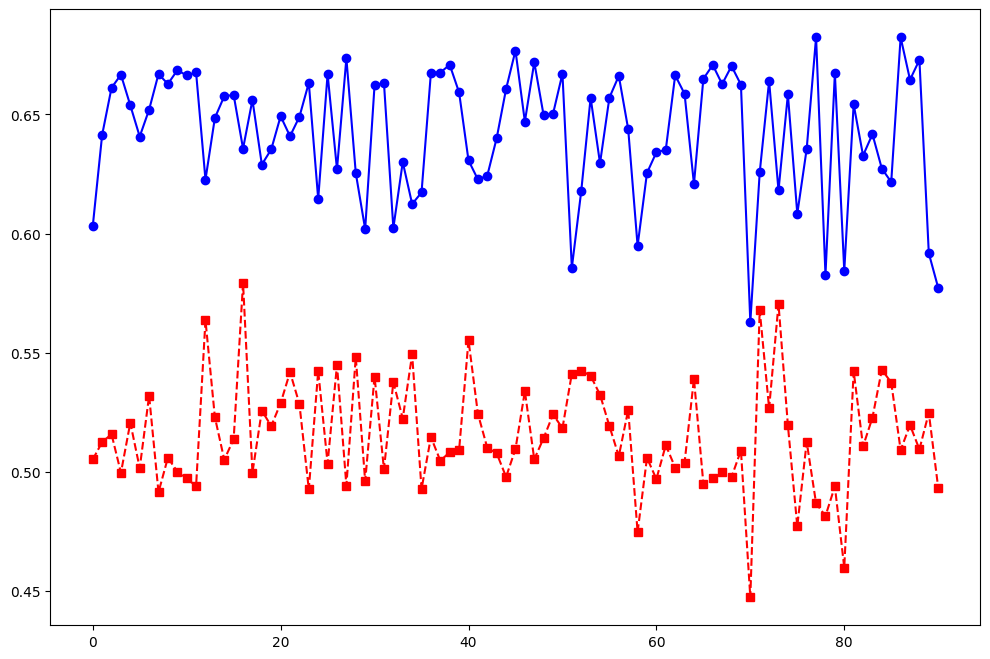

In [111]:
import matplotlib.pyplot as plt

probs = []
prob2 = []
prob3 = []
prob4 = []
for item in data:
    probs.append(item['pred2prob'][0][9])
    prob2.append(item['pred2prob'][0][7])
    # prob3.append(item['pred2prob'][0][7])
    # prob4.append(item['pred2prob'][0][8])
    

idxs = []
for i in range(len(probs)):
    idxs.append(i)
plt.figure(figsize=(12, 8))
plt.plot(idxs, probs, label="Class 0", marker="o", linestyle="-", color="blue")
plt.plot(idxs, prob2, label="Class 2", marker="s", linestyle="--", color="red")
# plt.plot(idxs, prob3, label="Class 10", marker="d", linestyle="-.", color="green")
# plt.plot(idxs, prob4, label="Class 1s", marker="d", linestyle="-.", color="black")



In [114]:
import numpy as np
from scipy import stats

# Giả sử đây là danh sách xác suất của một class (có thể thay bằng prob1, prob2, prob3)
probabilities = prob2

# Tính các giá trị thống kê
mean_value = np.mean(probabilities)  # Giá trị trung bình
mode_value = stats.mode(probabilities) # Giá trị mode
median_value = np.percentile(probabilities, 50)  # Mức phân vị 50% (median)
percentile_25 = np.percentile(probabilities, 25)  # Mức phân vị 25%
percentile_75 = np.percentile(probabilities, 90)  # Mức phân vị 75%

# In kết quả
print(f"Mean (Trung bình): {mean_value:.4f}")
print(f"Mode (Giá trị xuất hiện nhiều nhất): {mode_value}")
print(f"Median (Phân vị 50%): {median_value:.4f}")
print(f"25th Percentile: {percentile_25:.4f}")
print(f"75th Percentile: {percentile_75:.4f}")
print(f"{np.percentile(probabilities, 100)}")


Mean (Trung bình): 0.5155
Mode (Giá trị xuất hiện nhiều nhất): ModeResult(mode=np.float64(0.44746458530426025), count=np.int64(1))
Median (Phân vị 50%): 0.5113
25th Percentile: 0.5000
75th Percentile: 0.5425
0.5792522430419922


In [64]:
probs

[0.35415831208229065,
 0.3119780421257019,
 0.2892568111419678,
 0.2844412326812744,
 0.3136094808578491,
 0.31045815348625183,
 0.294851690530777,
 0.2767133414745331,
 0.2881782054901123,
 0.2850722074508667,
 0.27740031480789185,
 0.2732817828655243,
 0.3305553197860718,
 0.3084353804588318,
 0.2891785502433777,
 0.28582441806793213,
 0.31458398699760437,
 0.28324514627456665,
 0.31967729330062866,
 0.3052866458892822,
 0.30058836936950684,
 0.29683130979537964,
 0.3101184666156769,
 0.27858251333236694,
 0.3618680536746979,
 0.28869304060935974,
 0.32248952984809875,
 0.27640002965927124,
 0.30720314383506775,
 0.36707910895347595,
 0.28888946771621704,
 0.27795830368995667,
 0.38610249757766724,
 0.316300630569458,
 0.33897924423217773,
 0.3312044143676758,
 0.28720733523368835,
 0.28595513105392456,
 0.28182387351989746,
 0.2867228388786316,
 0.30231186747550964,
 0.3157203197479248,
 0.31835857033729553,
 0.29497578740119934,
 0.2819024324417114,
 0.2838253974914551,
 0.31966465